This notebook maps electrode channels (the midpoint between two contacts) to hippocmapal surfaces. Channel data are all in space-MNI152 from the Frauscher et al. atlas. Thus, to compute a hippocmapal surface in this space, we register all MICs subjects to space-MNI152 and then average hippocmapal surfaces in that space. We then map bandpower in the same was as iEEG_MICs.ipynb.

For a more detailed explanation of code, see `notebooks/iEEG.ipynb`

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import nibabel as nib
import glob
import sys
import hippomaps as hm
import pandas as pd
import scipy.io
from scipy.signal import periodogram
import pygeodesic.geodesic as geodesic
from scipy.ndimage import gaussian_filter1d

In [25]:
micapipe_dir = '/export03/data/publication-hippomap/sourcedata/Micapipe_MICs'
ieeg_local = '/export03/data/publication-hippomaps/sourcedata/iEEG-local/'
hippunfold_dir = '/export03/data/publication-hippomap/hippunfold/MICs_v1.3.0/hippunfold'
sub = glob.glob(ieeg_local + '/sub-PX???_*.mat')
for i in range(len(sub)): sub[i] = sub[i].split('/')[-1][4:9]
ses = 'ses-01'
den='2mm'
hemis = ['L','R']
labels = ['hipp']#,'dentate'] 

# get expected number of vertices and their indices
nV,iV = hm.config.get_nVertices(labels,den) 

freq = 200 #Hz
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']
band_lims = np.array([[0.5,4], [4,8], [8,13], [13,30], [30,80]])
sampspace = np.arange(0.5,80,0.5)
dist_threshold = 5 #mm

colormap = pl.cm.Set1(range(10))

In [22]:
atlasdat = scipy.io.loadmat(f'{ieeg_local}/Frauscher-wakefullnes.mat')

In [23]:
atlasdat['ChannelName'].shape

(1772, 1)

In [26]:
# ensure same space
# these should all be postive after applying the inverse affine
ref = nib.load('/data/mica1/01_programs/micapipe-v0.2.0/MNI152Volumes/MNI152_T1_1mm.nii.gz')
V = atlasdat['ChannelPosition'] - ref.affine[:3,3]
V[:,0] = -V[:,0]
print(np.min(V,axis=0))
print(np.max(V,axis=0))

In [27]:
pxx = np.zeros((len(sampspace),len(atlasdat['ChannelPosition'])))
for c in range(len(atlasdat['ChannelPosition'])):
    f,p = scipy.signal.welch(atlasdat['Data'][:,c])
    interpolator = scipy.interpolate.interp1d(f*freq,p/np.sum(p))
    pxx[:,c] = interpolator(sampspace)

In [28]:
pxx.shape

(159, 1772)

(0.4, 100)

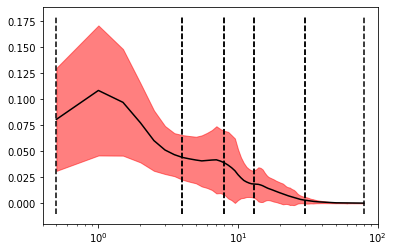

In [29]:
y = np.nanmean(pxx,axis=1)
err = np.nanstd(pxx,axis=1)
plt.plot(sampspace,y,'k-')
plt.fill_between(sampspace, y-err, y+err, alpha=0.5, color='r')
plt.vlines(band_lims.flatten(),plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],colors='k',linestyles='--')
plt.xscale('log')
plt.xlim(0.4,100)

In [31]:
bp = np.zeros((pxx.shape[1], len(bands)))
for b in range(len(bands)):
    for c in range(atlasdat['Data'].shape[1]):
        mask = np.logical_and(sampspace>band_lims[b,0], sampspace<band_lims[b,1])
        bp[c,b] = np.trapz(pxx[mask,c],sampspace[mask])

/data/mica1/01_programs/tmp/ipykernel_46051/892831248.py:19: UserWarning: Legend does not support handles for Axes instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(handles=ax[1:])


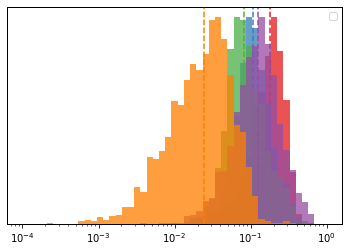

In [32]:
color_discrete = pl.cm.Set1(range(10))
l=['delta', 'theta', 'alpha', 'beta', 'gamma']
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.yaxis.set_visible(False)
ax = [ax]
n=0
cbins=[]
for b in range(5):
    ax = ax + [ax[0].twinx()]
    dat = bp[:,b]
    plt.axvline(x=np.nanmedian(dat), color=color_discrete[n], linestyle='dashed')
    ax[n+1].hist(dat,bins=np.logspace(np.log10(1e-4),np.log10(1), 50), linestyle=None, alpha=0.5, 
               color=color_discrete[b], label=l[b]);
    cbins.append(ax[n+1].hist(dat,bins=np.logspace(np.log10(1e-4),np.log10(1), 50), linestyle=None, alpha=0.5, 
               color=colormap[b], label=l[b]))
    ax[n+1].yaxis.set_visible(False)
    n=n+1
plt.legend(handles=ax[1:])

## Localization
Here, we have the vertices associated with each channel that falls within 5mm of the hippocampus. 

In [33]:
surfL = nib.load('/export03/data/opt/hippunfold-templateflow/tpl-MNI152NLin2009cSym/tpl-MNI152NLin2009cSym_hemi-L_space-T1w_den-2mm_label-hipp_midthickness.surf.gii')
surfR = nib.load('/export03/data/opt/hippunfold-templateflow/tpl-MNI152NLin2009cSym/tpl-MNI152NLin2009cSym_hemi-R_space-T1w_den-2mm_label-hipp_midthickness.surf.gii')
vertices = np.stack((surfL.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data,surfR.get_arrays_from_intent('NIFTI_INTENT_POINTSET')[0].data),axis=2)
faces = surfL.get_arrays_from_intent('NIFTI_INTENT_TRIANGLE')[0].data

In [34]:
dist_threshold = 5 #mm
hipp_bp_count = np.zeros([nV])
hipp_bp = np.ones([nV,2,5,len(atlasdat['ChannelPosition'])])*np.nan
hipp_pxx = np.ones([nV,2,pxx.shape[0],len(atlasdat['ChannelPosition'])])*np.nan

for h in range(len(hemis)):
    for i in range(len(atlasdat['ChannelPosition'])):
        for v in range(len(vertices)):
            dist = np.linalg.norm(atlasdat['ChannelPosition'][i]-vertices[v,:,h])
            if dist <= dist_threshold:
                hipp_bp[v,h,:,i] = bp[i,:]
                hipp_pxx[v,h,:,i] = pxx[:,i]

In [35]:
print('number of L hemis: ' + str(len(np.where(np.any(~np.isnan(hipp_bp[:,0,0,:]),axis=0))[0])))
print('number of R hemis: ' + str(len(np.where(np.any(~np.isnan(hipp_bp[:,1,0,:]),axis=0))[0])))

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


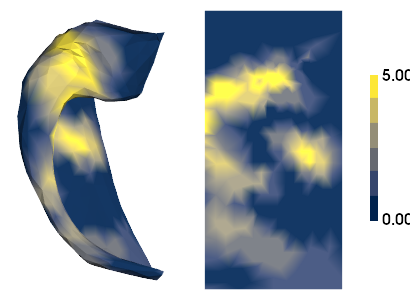

In [36]:
hipp_bp_count = np.sum(~np.isnan(hipp_bp),axis=(1,3))[:,0]
hm.plotting.surfplot_canonical_foldunfold(hipp_bp_count, den='2mm', hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

(0.4, 100)

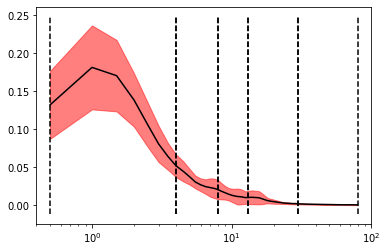

In [37]:
y = np.nanmean(hipp_pxx,axis=(0,1,3))
err = np.nanstd(hipp_pxx,axis=(0,1,3))
plt.plot(sampspace,y,'k-')
plt.fill_between(sampspace, y-err, y+err, alpha=0.5, color='r')
plt.vlines(band_lims.flatten(),plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],colors='k',linestyles='--')
plt.xscale('log')
plt.xlim(0.4,100)

(0.4, 100)

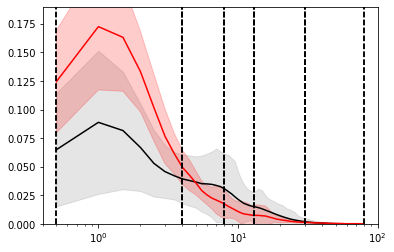

In [38]:
y = np.exp(np.nanmean(np.log(pxx),axis=1))
err = np.nanstd(pxx,axis=1)
plt.plot(sampspace,y,'k')
plt.ylim(0,.19)
plt.fill_between(sampspace, y-err, y+err, alpha=0.2, color='gray')
plt.vlines(band_lims.flatten(),plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],colors='k',linestyles='--')
plt.xscale('log')
plt.xlim(0.4,100)

y = np.exp(np.nanmean(np.log(hipp_pxx),axis=(0,1,3)))
err = np.nanstd(hipp_pxx,axis=(0,1,3))
plt.plot(sampspace,y,'r')
plt.ylim(0,.19)
plt.fill_between(sampspace, y-err, y+err, alpha=0.2, color='r')
plt.vlines(band_lims.flatten(),plt.gca().get_ylim()[0],plt.gca().get_ylim()[1],colors='k',linestyles='--')
plt.xscale('log')
plt.xlim(0.4,100)

/data/mica1/01_programs/tmp/ipykernel_46051/2180602821.py:19: UserWarning: Legend does not support handles for Axes instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(handles=ax[1:])


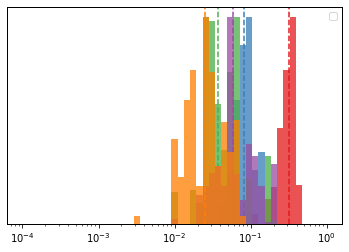

In [39]:
color_discrete = pl.cm.Set1(range(10))
l=['delta', 'theta', 'alpha', 'beta', 'gamma']
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.yaxis.set_visible(False)
ax = [ax]
n=0
hippcbins=[]
for b in range(5):
    ax = ax + [ax[0].twinx()]
    dat = hipp_bp[:,:,b,:].flatten()
    plt.axvline(x=np.nanmedian(dat), color=color_discrete[n], linestyle='dashed')
    ax[n+1].hist(dat,bins=np.logspace(np.log10(1e-4),np.log10(1), 50), linestyle=None, alpha=0.5, 
               color=color_discrete[b], label=l[b]);
    hippcbins.append(ax[n+1].hist(dat,bins=np.logspace(np.log10(1e-4),np.log10(1), 50), linestyle=None, alpha=0.5, 
               color=colormap[b], label=l[b]))
    ax[n+1].yaxis.set_visible(False)
    n=n+1
plt.legend(handles=ax[1:])

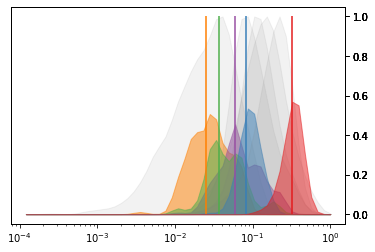

In [40]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.yaxis.set_visible(False)
ax = [ax]
sigma = 1
n=0
for b in reversed(range(5)):
    ax = ax + [ax[0].twinx()]
    dat = bp[:,b]
    #ax[n+1].vlines(np.nanmedian(dat),0,1, color='gray', linestyle='dashed')
    plt.fill_between(cbins[b][1][1:],gaussian_filter1d(cbins[b][0],sigma), color='gray', alpha=0.1)
    ax[n+1].yaxis.set_visible(False)
    n=n+1
n=0
for b in reversed(range(5)):
    ax = ax + [ax[0].twinx()]
    dat = hipp_bp[:,:,b,:].flatten()
    plt.vlines(np.nanmedian(dat),0,1, color=colormap[b], linestyle='solid')
    ax[n+1].fill_between(hippcbins[b][1][1:],gaussian_filter1d(hippcbins[b][0],sigma), color=colormap[b], alpha=0.5)
    #ax[n+1].hist(dat,bins=np.logspace(np.log10(1e-4),np.log10(1), 50), linestyle=None, alpha=0.5, 
    #           color=colormap[b], label=l[b]);
    ax[n+1].yaxis.set_visible(False)
    n=n+1

## Extrapolation
We can see that simply averaging over all channels doesn't give a good idea of the spatial distribution of band power, since so much data is missing. Thus, we will extrapolate each channel over the whole hippocampus and then use the distance from the channel as a weighting when performing weighted averaging across channels. See `../extras` for an example visualization.

In [42]:
dat.shape

(419,)

In [46]:
# cominbing BP across channels and vertices for visualization
# here, we exctrapoalte the data from any channel across the entire hippocampus, and then average across all channels. However, the average across channels is weighted by distance to the actual channel contact. 

weights_hipp_bp = np.zeros((hipp_bp.shape[0],2,hipp_bp.shape[3]))
interp_hipp_bp = np.zeros([hipp_bp.shape[0],5])
interp_hipp_perio_dat = np.zeros([hipp_bp.shape[0],len(pxx)])

for h,hemi in enumerate(hemis):
    for l,label in enumerate(labels):
        for c in range(hipp_bp.shape[3]):
            dat = hipp_bp[:,h,0,c]
            mask = ~np.isnan(dat[iV[l]])
            if np.any(mask):
                geoalg = geodesic.PyGeodesicAlgorithmExact(vertices[:,:,h], faces)
                sd,_ = geoalg.geodesicDistances(np.where(mask)[0], None)
                sd = sd**2
                weights_hipp_bp[iV[l],h,c] = 1 - (sd/np.max(sd))
totweights = np.nansum(weights_hipp_bp, axis=(1,2))
for v in range(weights_hipp_bp.shape[0]):
    for h in range(2):
        for c in range(hipp_bp.shape[3]):
            w = weights_hipp_bp[v,h,c] / totweights[v]
            if w>0:
                interp_hipp_bp[v,:] += np.nanmean(hipp_bp[:,h,:,c],axis=0) * w
                interp_hipp_perio_dat[v,:] += np.nanmean(hipp_pxx[:,h,:,c],axis=0) * w

/export03/data/opt/venv/lib/python3.8/site-packages/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


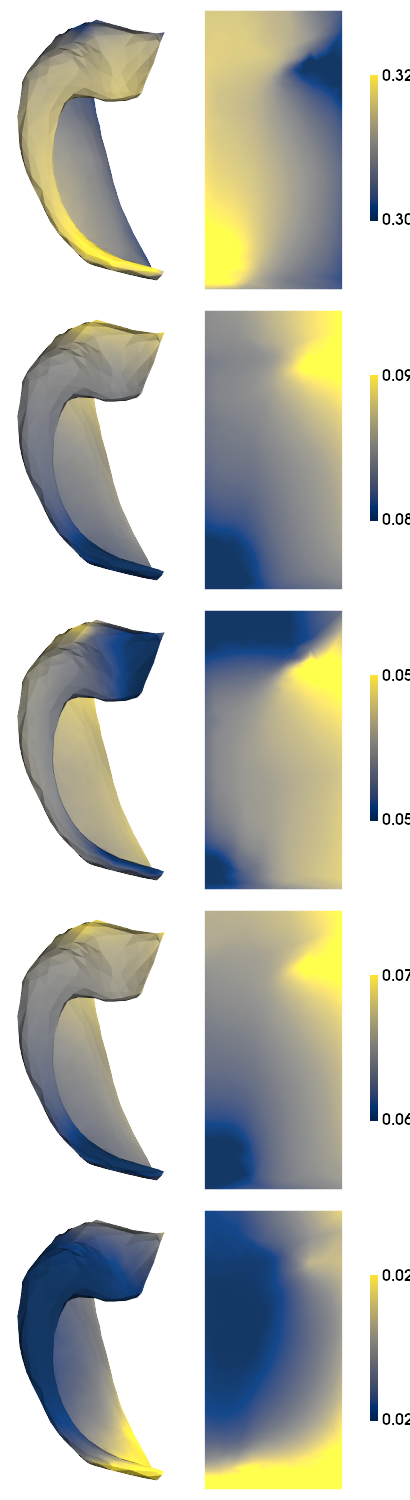

In [47]:
hm.plotting.surfplot_canonical_foldunfold(interp_hipp_bp, den=den, hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='cividis', share='row', color_bar='right', embed_nb=True)

# Band power gradients

In [ ]:
from brainspace.gradient import GradientMaps
# gradient decomposition
bpgm = GradientMaps(n_components=5, kernel='normalized_angle')
bpgm.fit(interp_hipp_perio_dat)

GradientMaps(kernel='normalized_angle', n_components=5)

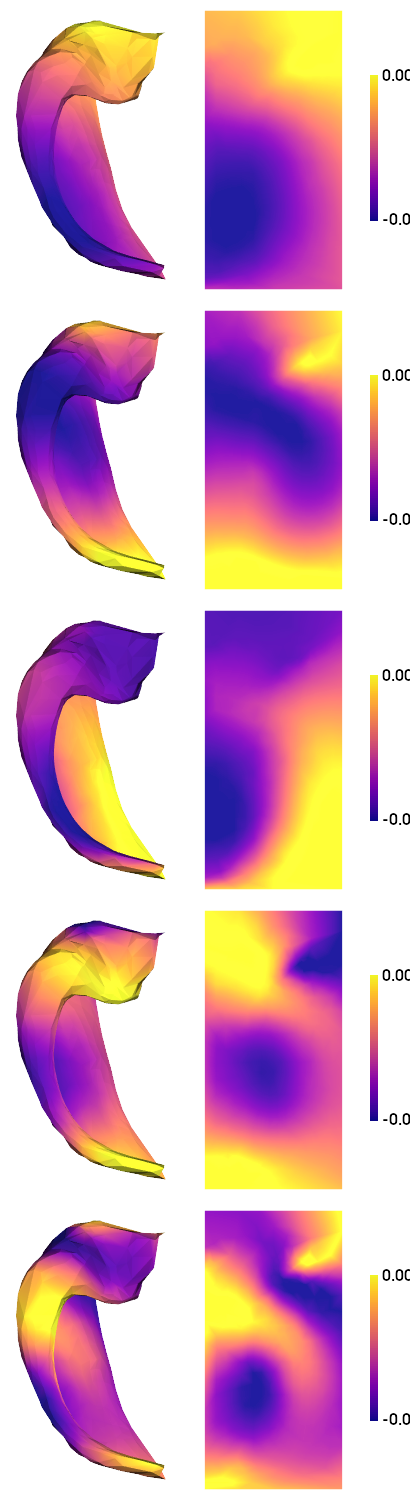

In [ ]:
hm.plotting.surfplot_canonical_foldunfold(bpgm.gradients_, den=den, hemis=['L'], labels=labels, unfoldAPrescale=True, tighten_cwindow=True, cmap='plasma', share='row', color_bar='right', embed_nb=True)

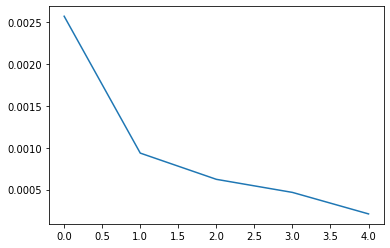

In [ ]:
plt.plot(bpgm.lambdas_)

In [48]:
vars_to_load = [pxx, bp, hipp_bp, hipp_pxx]
!mkdir -p ../checkpoints
np.save(f'../checkpoints/iEEG_Frauscher_dat', vars_to_load, allow_pickle=True,)

/export03/data/opt/venv/lib/python3.8/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
